In [1]:
from qwak.qwak import QWAK
from utils.plotTools import searchProbStepsPlotting,searchProbStepsPlotting2

import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from math import sqrt, ceil, pow
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp
import math
from qwak.State import State
from qwak.Operator import Operator
from qwak.QuantumWalk import QuantumWalk
from qwak.ProbabilityDistribution import ProbabilityDistribution
from qwak.qwak import QWAK
import copy
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.ndimage import gaussian_filter


In [4]:
def smooth_matrices(matrix1, matrix2, matrix3, sigma=1):
    """
    Applies 2D Gaussian smoothing to three input matrices.
    
    Parameters:
        matrix1 (numpy array): first input matrix
        matrix2 (numpy array): second input matrix
        matrix3 (numpy array): third input matrix
        sigma (float): standard deviation of the Gaussian filter
    
    Returns:
        tuple: a tuple of three smoothed matrices
    """
    smoothed_matrix1 = gaussian_filter(matrix1, sigma=sigma)
    smoothed_matrix2 = gaussian_filter(matrix2, sigma=sigma)
    smoothed_matrix3 = gaussian_filter(matrix3, sigma=sigma)
    
    return (smoothed_matrix1, smoothed_matrix2, smoothed_matrix3)

def write_nested_list_to_file(file_path, nested_lst):
    """
    Write a nested list of elements to a text file.
    
    :param file_path: the file path where to write the nested list
    :param nested_lst: the nested list of elements to write
    """
    with open(file_path, 'w') as f:
        for lst in nested_lst:
            for item in lst:
                f.write(f"{item} ")
            f.write("\n")

def load_nested_list_from_file(file_path):
    """
    Load a nested list of float elements from a text file.
    
    :param file_path: the file path to load the nested list from
    :return: the nested list of float elements loaded from the file
    """
    nested_lst = []
    with open(file_path, 'r') as f:
        for line in f:
            lst = [float(item) for item in line.strip().split()]
            nested_lst.append(lst)
    return nested_lst

def plotSearch(N,probT,tSpace,configVec):
    plotName = ""
    for T,walk,config,n in zip(tSpace,probT,configVec,N):
        #print(config)
        plt.plot(T,walk,color=config[0],linestyle=config[1],label="N=%s"%n)
        plt.vlines(max(T),0,1,color=config[0],linestyle=config[2])
        plt.legend()
        plt.xlabel("Number of steps")
        plt.ylabel("Probability of marked elements")
    for n in N:
        plotName+='_'+str(n)
    plt.savefig(r"C:\Users\jaime\Documents\GitHub\QWAK\Notebook\Output\\"+f"Search{plotName}")
    # plt.clf()
    
def plotSearch2(markedList, probT, tSpace, configVec,labels):
    %matplotlib inline
    plotName = ""
    fig = plt.figure()
    for T, walk, config, marked, label in zip(tSpace, probT, configVec, markedList,labels):
        plt.plot(T, walk, color=config[0], linestyle=config[1], label=label)
        plt.vlines(max(T), 0, max(probT[0]), color=config[0], linestyle=config[2])
        #plt.legend()
        plt.xlabel("Number of steps")
        plt.ylabel("Probability of marked elements")
    for marked in markedList:
        plotName += '_' + str(len(marked))
    return fig
    
def taylor_series_approximation(n, num_terms):
    approx = 0
    for i in range(num_terms):
        approx += ((-1)**i) * (n**(-2*i-2)) / math.factorial(2*i+2)
    return approx

def taylor_series_approximation2(n, order):
    taylor_series = 0
    for i in range(order):
        taylor_series += (-1)**i * sp.binom(order, i) * (1/n)**(order - i)
    return taylor_series

def approx_1_over_n_squared(n,order):
    sum = 0
    for i in range(0, order):
        sum += 1 / (n ** (2+i))
    return sum

colors = ['r','b','g','k']
lines = ['-','-','-','-']
lines2 = ['--','--','--','--']
configVec = zip(colors,lines,lines2)


def init(N):
    psi0 = np.ones((N,1))/ np.sqrt(N)
    return psi0

def adjMatrix(N):
    adjM = np.ones((N,N),dtype='complex') - np.eye(N)
    return adjM


def hamiltonean(N,adjM,marked,gamma):
    H = -(gamma*adjM)
    H[marked][marked] = -1
    return H

def evo(H,t):
    U = expm(-1j*H*t)
    return U

def fin(N,evo):
    psiN = init(N)
    psiN = evo.dot(psiN)
    return psiN

def ampToProb(N,psiN,marked):
    prob = np.zeros((N,1))
    probMarked = np.zeros((N,1))
    for x in range(N):
        prob[x] += (np.absolute(psiN[x])**2)
        probMarked[x] += (np.absolute(psiN[marked])**2)
    return prob,probMarked

# Grover's Algorithm

In [4]:
def init(N):
    psi0 = np.ones((N,1))/ np.sqrt(N)
    return psi0

def oracle(N,marked):
    oracle = np.eye(N)
    for mark in marked:
        oracle[mark][mark] = -1
    return oracle

def diffusion(N):
    ketSuper = np.ones((N,1))/ np.sqrt(N)
    diff = 2 * np.outer(ketSuper,ketSuper) - np.eye(N)
    return diff

def unitary(N,marked):
    orac = oracle(N,marked)
    diff = diffusion(N)
    return np.dot(diff,orac)

def spaceGen(N):
    stepVec = []
    tVec = []
    for n in N:
        idealSteps = np.floor((np.pi/4)*np.sqrt(n))
        stepVec.append(int(idealSteps))
    return stepVec

def groverSimpleSearch(N,steps,marked):
    u = unitary(N,marked)
    prob = []
    psiN = init(N)
    for i in range(0,steps):
        psiN = np.dot(u,psiN)
    return np.absolute(psiN**2)

def groverSearch(N,stepSpace,marked):
    prob = []
    probT = []
    for n,steps in zip(N,stepSpace):
        u = unitary(n,marked)
        psiN=init(n)
        prob += [np.absolute(psiN[marked][0][0])**2]
        for step in range(1,steps+1):
            psiN = np.dot(u,psiN)
            prob+=[np.absolute(psiN[marked][0][0]**2)]
        probT.append(prob)
        prob = []
    return probT

## Single element Grover Search

In [28]:
# n=[200]
n=200
# steps = spaceGen(n)
steps = int(np.floor((np.pi/4) * np.sqrt(n)))
print(steps)
marked = [n//2]
# grover = groverSearch(n,steps,marked)[0]
groverSingleElement = groverSimpleSearch(n,steps,marked)

# plt.plot(groverSingleElement)

11


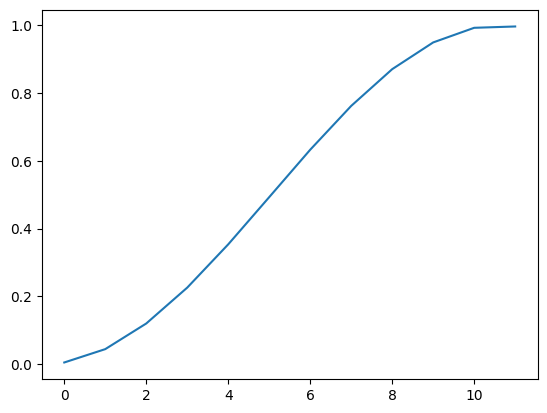

In [29]:
n=[200]
steps = spaceGen(n)
marked = [n[0]//2]
groverSingleElement2 = groverSearch(n,steps,marked)[0]
plt.plot(groverSingleElement2)

## Multiple element Grover Search

In [30]:
# n=[200]
n=200
# steps = spaceGen(n)
marked = [n//2-n//4,n//2,n//2+n//4]
steps = int(np.floor((np.pi/4) * np.sqrt(n/len(marked))))
print(steps)
# grover = groverSearch(n,steps,marked)[0]
groverMultipleElement = groverSimpleSearch(n,steps,marked)

# plt.plot(groverMultipleElement)

6


## Single Shot Grover Search

In [31]:
# n=[200]
n=200
# steps = spaceGen(n)
marked = [x for x in range(n//4,n//2)]
steps = int(np.floor((np.pi/4) * np.sqrt(n/len(marked))))
print(steps)
# grover = groverSearch(n,steps,marked)[0]
groverSingleShot = groverSimpleSearch(n,steps,marked)

# plt.plot(groverSingleShot)

1


# CTQW Search

## Single element CTQW Search

In [9]:
n=200
t = (np.pi/2) * np.sqrt(n) + 5
gamma = 1/n
initCond = list(range(0,n))
graph = nx.complete_graph(n)

qw = QWAK(graph=graph,gamma=gamma,markedElements=[(n//2,-1)],laplacian=False)
qw.runWalk(time=t,initStateList=initCond)

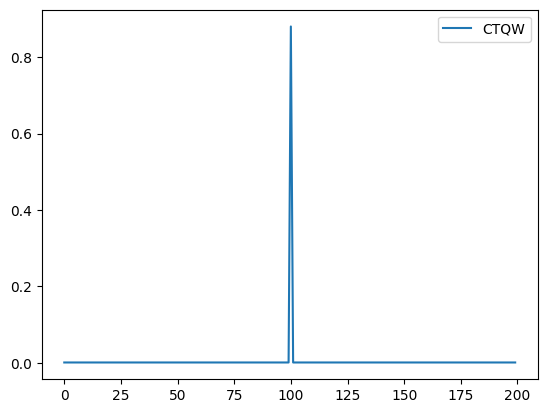

In [10]:
plt.plot(qw.getProbVec(),label='CTQW')
plt.legend()

# Multiple element Search

In [34]:
n=200
markedSearch = [(n//4,-1),(n//2,-1),(n//2+n//4,-1)]
t = (np.pi/2) * np.sqrt(n/len(markedSearch))
gamma = 1/n
initCond = list(range(0,n))
graph = nx.complete_graph(n)

qw = QWAK(graph=graph,gamma=gamma,markedElements=markedSearch,laplacian=True)
qw.runWalk(time=t,initStateList=initCond)
prob=0
for element in markedSearch:
    prob+= qw.getProbVec()[element[0]]

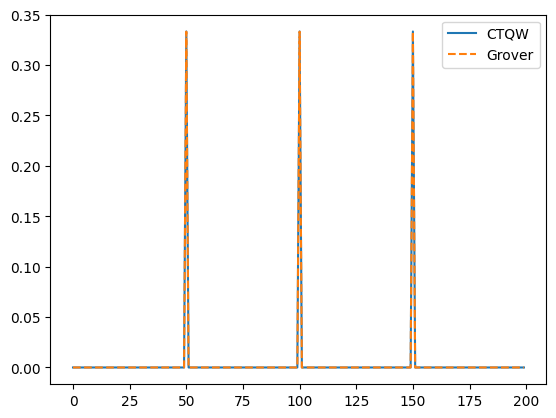

In [35]:
plt.plot(qw.getProbVec(),label='CTQW')
plt.plot(groverMultipleElement,label='Grover',linestyle='dashed')
plt.legend()

# Single Shot Grover Walk

In [36]:
k = 6
n=  200
markedSearch = [(x,-1) for x in range(n//4,n//2)]

t = (np.pi/2) * np.sqrt(n/len(markedSearch))
print(t)
gamma = 1/n
initCond = list(range(0,n))
graph = nx.complete_graph(n)

qw = QWAK(graph=graph,gamma=gamma,markedElements=markedSearch,laplacian=True)
qw.runWalk(time=t,initStateList=initCond)

3.141592653589793


# Other Experiments

## Probability vs number of steps as a function of #marked elements

In [13]:
n=200
markedSearch = [(x,-1) for x in range(1,n//16)]
t = (np.pi/2) * np.sqrt(n/len(markedSearch))

gamma = 1/n
initCond = list(range(0,n))
graph = nx.complete_graph(n)

timeList = [ x for x in np.linspace(0,t,50)]

qw = QWAK(graph=graph,gamma=gamma,markedElements=markedSearch,laplacian=True)
qw.runMultipleWalks(timeList=timeList,initStateList=initCond)
markedProbList = searchProbStepsPlotting(qw)

######

markedSearch2 = [(x,-1) for x in range(1,n//8)]

t = (np.pi/2) * np.sqrt(n/len(markedSearch2))
gamma = 1/n
initCond = list(range(0,n))
graph = nx.complete_graph(n)

timeList2 = [ x for x in np.linspace(0,t,50)]

qw2 = QWAK(graph=graph,gamma=gamma,markedElements=markedSearch2,laplacian=True)
qw2.runMultipleWalks(timeList=timeList2,initStateList=initCond)
markedProbList2 = searchProbStepsPlotting(qw2)

########

markedSearch3 = [(x,-1) for x in range(1,n//4)]

t = (np.pi/2) * np.sqrt(n/len(markedSearch3))
gamma = 1/n
initCond = list(range(0,n))
graph = nx.complete_graph(n)

timeList3 = [ x for x in np.linspace(0,t,50)]

qw3 = QWAK(graph=graph,gamma=gamma,markedElements=markedSearch3,laplacian=True)
qw3.runMultipleWalks(timeList=timeList3,initStateList=initCond)
markedProbList3 = searchProbStepsPlotting(qw3)

#######

markedSearchSingle = [(x,-1) for x in range(1,n//4)]

t = (np.pi/2) * np.sqrt(n/len(markedSearchSingle))
gamma = 1/n
initCond = list(range(0,n))
graph = nx.complete_graph(n)

timeListSingle = [ x for x in np.linspace(0,t,50)]

qwSingle = QWAK(graph=graph,gamma=gamma,markedElements=markedSearchSingle,laplacian=True)
qwSingle.runMultipleWalks(timeList=timeListSingle,initStateList=initCond)
markedProbListSingle = searchProbStepsPlotting(qwSingle)




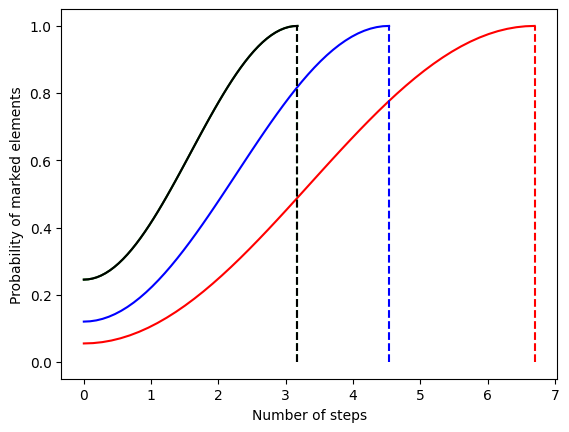

In [14]:
plotSearch2([markedSearch,markedSearch2,markedSearch3,markedSearchSingle],[markedProbList,markedProbList2,markedProbList3,markedProbListSingle],[timeList,timeList2,timeList3,timeListSingle],configVec,labels = [f'{len(markedSearch)}',f'{len(markedSearch2)}',f'{len(markedSearch3)}',f'{len(markedSearchSingle)}'])
plt.show()

## Multiple single element searches

In [39]:
numberOfWalks = 4
minWalkSize = 3
nList = [2**x for x in range(minWalkSize,numberOfWalks+minWalkSize)]

tList = [(np.pi/2) * np.sqrt(x) for x in nList]

gammaList = [1/x for x in nList]

markedSearchList =[[(x//2,-1)] for x in nList]


qwakList = []

for (t,markedSearch,n,gamma) in zip(tList,markedSearchList,nList,gammaList):
    graph = nx.complete_graph(n)
    qw = QWAK(graph=graph,gamma=gamma,markedElements=markedSearch,laplacian=True)
    initCond = list(range(0,n))
    qw.runWalk(time=t,initStateList=initCond)
    qwakList.append(qw)


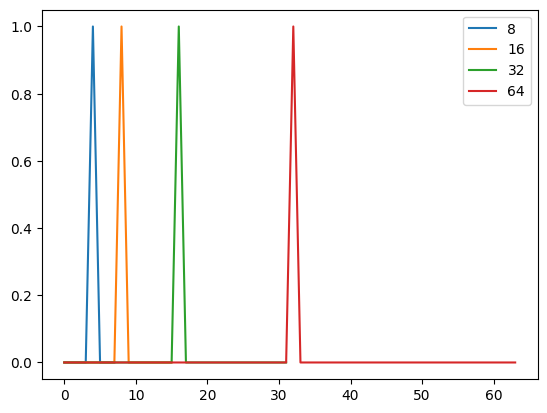

In [40]:
for qwak in qwakList:
    plt.plot(qwak.getProbVec(),label=f"{qwak.getDim()}")
plt.legend()

## Various multiple element searches

In [41]:
numberOfWalks = 5
minWalkSize = 3
nList = [2**x for x in range(minWalkSize,numberOfWalks+minWalkSize)]


gammaList = [1/x for x in nList]

nMarkedElements = 3
markedSearchList =[[(x//2+k,-1) for k in range(0,nMarkedElements)] for x in nList]

tList = [(np.pi/2) * np.sqrt(x/nMarkedElements) for x in nList]

qwakList = []

for (t,markedSearch,n,gamma) in zip(tList,markedSearchList,nList,gammaList):
    graph = nx.complete_graph(n)
    qw = QWAK(graph=graph,gamma=gamma,markedElements=markedSearch,laplacian=True)
    initCond = list(range(0,n))
    qw.runWalk(time=t,initStateList=initCond)
    qwakList.append(qw)


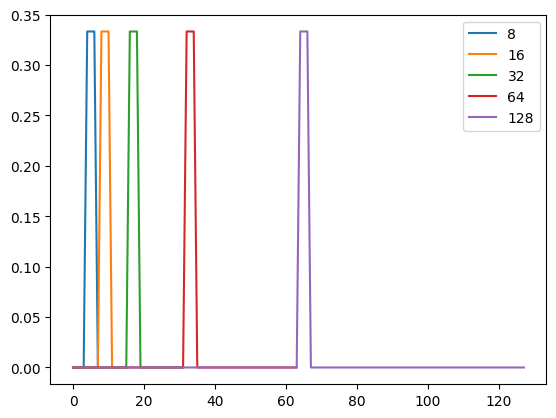

In [42]:
for qwak in qwakList:
    plt.plot(qwak.getProbVec(),label=f"{qwak.getDim()}")
    
plt.legend()

## Multiple Single Shot Grover searches

In [47]:
numberOfWalks = 5
minWalkSize = 3
nList = [2**x for x in range(minWalkSize,numberOfWalks+minWalkSize)]


gammaList = [1/x for x in nList]

nMarkedElementsList = [x//4 for x in nList]
print(nMarkedElementsList)

markedSearchListAux = []
markedSearchList =[]
# markedSearchList =[[(x//4+k,-1) for k in range(y) ] for x,y in zip(nList,nMarkedElementsList)]
for x,n in zip(nMarkedElementsList,nList):
    for k in range(x):
        markedSearchListAux.append((n//4+k,-1))
        
    markedSearchList.append(markedSearchListAux)
    markedSearchListAux = []
    
print(len(markedSearchList))
tList = [(np.pi/2) * np.sqrt(x/len(y)) for x,y in zip(nList,markedSearchList)]

qwakList = []

for (t,markedSearch,n,gamma) in zip(tList,markedSearchList,nList,gammaList):
    graph = nx.complete_graph(n)
    qw = QWAK(graph=graph,gamma=gamma,markedElements=markedSearch,laplacian=True)
    initCond = list(range(0,n))
    qw.runWalk(time=t,initStateList=initCond)
    print(f"qwakSize:{qw.getDim()}\t qwakTime:{qw.getTime()}")
    qwakList.append(qw)


[2, 4, 8, 16, 32]
5
qwakSize:8	 qwakTime:3.141592653589793
qwakSize:16	 qwakTime:3.141592653589793
qwakSize:32	 qwakTime:3.141592653589793
qwakSize:64	 qwakTime:3.141592653589793
qwakSize:128	 qwakTime:3.141592653589793


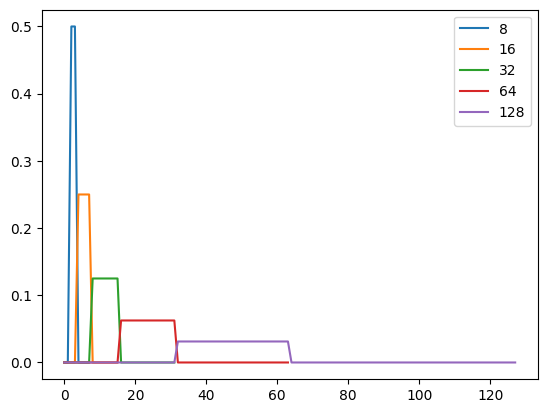

In [48]:
for qwak in qwakList:
    plt.plot(qwak.getProbVec(),label=f"{qwak.getDim()}")
    
plt.legend()

## Searching in a Hypercube

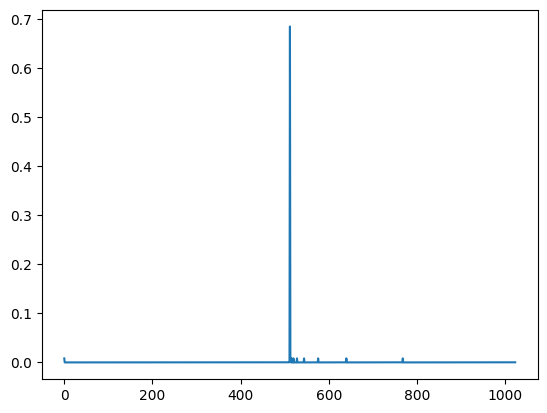

In [51]:
n=10
graph = nx.hypercube_graph(n)
gamma = 1/n + approx_1_over_n_squared(n,20)# Gamma do paper do renato https://arxiv.org/pdf/2212.08889.pdf

N = len(graph)
markedElements = [(N//2,-1)]

t = np.floor(np.pi/2 * sqrt(N)) 
initCond = list(range(0,len(graph)))


qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
qw.runExpmWalk(time=t,initStateList=initCond)
plt.plot(qw.getProbVec())

N = 64
(0.7614534256822126, 0.20459674873737374)


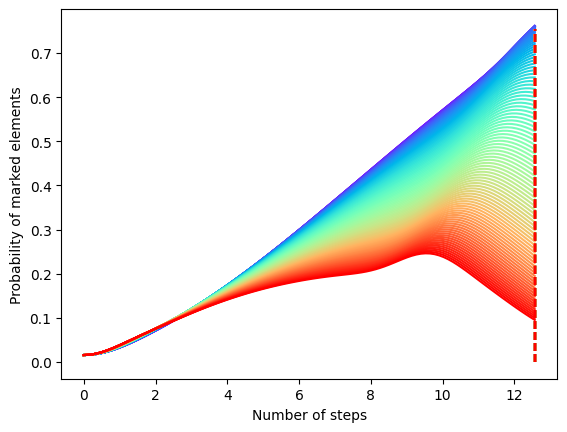

In [99]:
n=6
graph = nx.hypercube_graph(n)
gamma = 0
for k in range(1,n+1):
    gamma += ( math.factorial(n) / (math.factorial(k)*math.factorial(n-k)) ) * 1/k
gamma = gamma * (1/(2**n))/2

N = len(graph)
print(f'N = {N}')
initCond = list(range(0,len(graph)))

timeList = np.linspace(0, (np.pi/(2) * np.sqrt(N)),100)
gammaList = [gamma] + np.linspace(gamma,gamma+0.1 ,100).tolist()
# print(f'gammaList = {gammaList} \n gamma = {gamma}' )
markedProbList = []
markedSearch = []
timeListList = []
labelList = []
probDistList = []

colors = plt.cm.rainbow(np.linspace(0, 1, len(gammaList)))
lines = ['-']*len(gammaList)
lines2 = ['--']*len(gammaList)
configVec = zip(colors,lines,lines2)

for gamma in gammaList:
    qw = QWAK(graph=graph,gamma=gamma,markedElements=[(N//2,-1)],laplacian=False)
    for time in timeList:
        qw.runWalk(time=time,initStateList=initCond)
        probDistList.append(copy.deepcopy(qw.getProbDist()))
    markedProbList.append(searchProbStepsPlotting2(qw,probDistList))
    probDistList = []
    markedSearch.append( [(N//2,-1)])
    timeListList.append( timeList)
    labelList.append(f'{round(gamma,7)}')
    qw.resetWalk()


plotAux = []
plotS = plotSearch2(markedSearch,markedProbList,timeListList,configVec,labelList)
for plot,gamma in zip(markedProbList,gammaList):
    plotAux.append((max(plot),gamma))
    # print(f'gamma = {gamma} -> {plot}')
max_pair = max(plotAux, key=lambda pair: pair[0])
print(max_pair)
plt.show()


## Complete bipartite graph

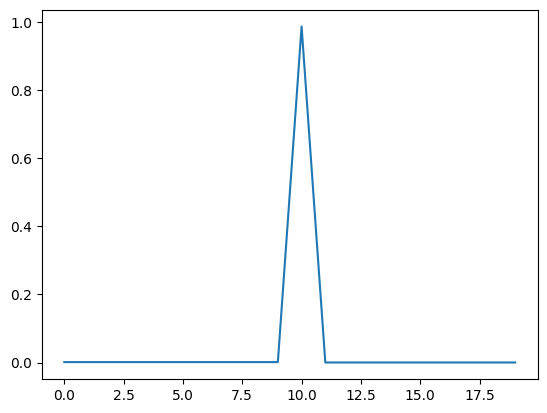

In [117]:
n1=10
n2 = 10
graph = nx.complete_bipartite_graph(n1,n2)
gamma = 1/n1 # Gamma do paper do renato https://arxiv.org/pdf/2212.08889.pdf

N = len(graph)
markedElements = [(N//2,-1)]

t = np.floor(np.pi/2 * sqrt(N)) 
initCond = list(range(0,len(graph)))


qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
qw.runExpmWalk(time=t,initStateList=initCond)
plt.plot(qw.getProbVec())

N = 64
(0.9920744901131057, 0.03125)


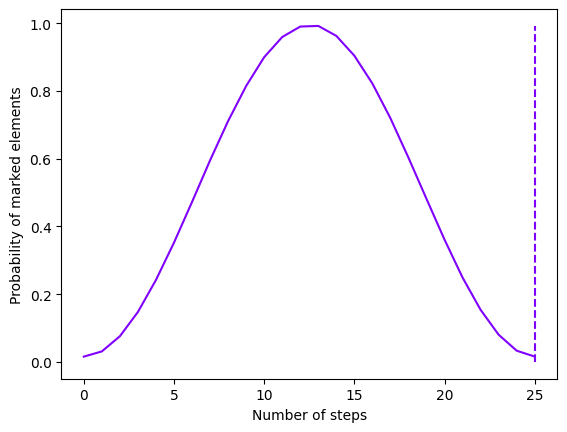

In [116]:
n1= 32
n2 = 32

graph = nx.complete_bipartite_graph(n1,n2)
gamma = 1/(n1) # Gamma do paper do renato https://arxiv.org/pdf/2212.08889.pdf

N = len(graph)
print(f'N = {N}')
initCond = list(range(0,len(graph)))

timeList = np.linspace(0, np.floor(2*(np.pi/(2) * np.sqrt(N))),26)
gammaList = [gamma] #+ np.linspace(gamma,gamma+0.1 ,100).tolist()
# print(f'gammaList = {gammaList} \n gamma = {gamma}' )
markedProbList = []
markedSearch = []
timeListList = []
labelList = []
probDistList = []

colors = plt.cm.rainbow(np.linspace(0, 1, len(gammaList)))
lines = ['-']*len(gammaList)
lines2 = ['--']*len(gammaList)
configVec = zip(colors,lines,lines2)

for gamma in gammaList:
    qw = QWAK(graph=graph,gamma=gamma,markedElements=[(N//2,-1)],laplacian=False)
    for time in timeList:
        qw.runWalk(time=time,initStateList=initCond)
        probDistList.append(copy.deepcopy(qw.getProbDist()))
    markedProbList.append(searchProbStepsPlotting2(qw,probDistList))
    probDistList = []
    markedSearch.append( [(N//2,-1)])
    timeListList.append( timeList)
    labelList.append(f'{round(gamma,7)}')
    qw.resetWalk()


plotAux = []
plotS = plotSearch2(markedSearch,markedProbList,timeListList,configVec,labelList)
for plot,gamma in zip(markedProbList,gammaList):
    plotAux.append((max(plot),gamma))
    # print(f'gamma = {gamma} -> {plot}')
max_pair = max(plotAux, key=lambda pair: pair[0])
print(max_pair)
plt.show()


## Periodic lattice

[5, 5, 5]


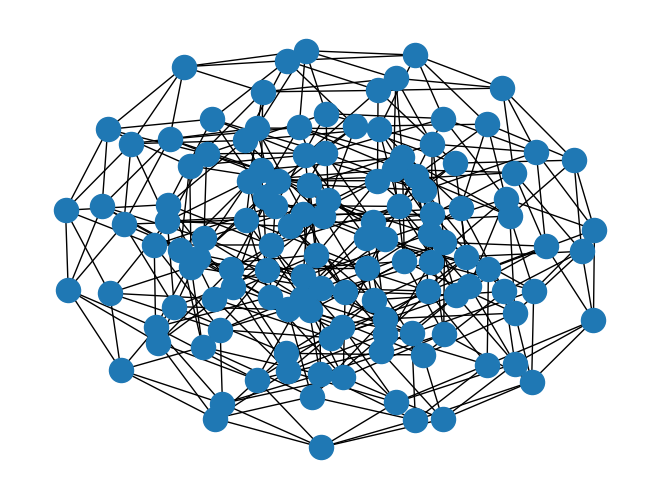

In [171]:
d = 3
N = 5
dim = [N]*d
print(dim)

graph = nx.grid_graph(dim=dim,periodic=True)
if d==2:
    pos = dict( (n, n) for n in graph.nodes() )
else:
    pos = None
nx.draw(graph,pos=pos)


In [ ]:
def epsilon(dim,kList): # pagina 5 equaçao 22
    aux = 0
    for j in range(1,d):
        aux += np.cos(kList[j])
    eps = 2*(d-aux)
    return eps

# Erdos-Renyi graphs

In [194]:
N = 100
pThresh = math.log(N,3/2)/N
print(pThresh)

t = np.pi/2 * sqrt(N)

#procurar funcao que testa se o grafo e conexo

timeList = [ x for x in np.linspace(0,t,50)]

markedElements = [(N//2,-1)]

# print(t)
probDistList = []

for p in np.linspace(pThresh/10, pThresh ,2):
    graph = nx.erdos_renyi_graph(N,p)
    if p>1:
        gamma = 1/N
    else:
        gamma = 1/(N*p)
    initCond = list(range(0,len(graph)))
    qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
    qw.runWalk(time=t,initStateList=initCond)
    probDistList.append(copy.deepcopy(qw.getProbVec()))

# for prob in probDistList:
#     plt.plot(prob)
#     print(max(prob))

0.11357747174535147


In [103]:
def multiple_erdos_renyi_qwak(N,pList,timeList,numberOfWalks,markedElements):
    markedProbMatrix = []
    markedProbList = [0]*len(timeList)
    probDistList = []
    for pVal in pList:
        for i in range(numberOfWalks):
            graph = nx.erdos_renyi_graph(N,pVal)
            if pVal>1:
                gamma = 1/N
            else:
                gamma = 1/(N*pVal)
            initCond = list(range(0,len(graph)))
            qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
            for t in timeList:
                qw.runWalk(time=t,initStateList=initCond)
                probDistList.append(copy.deepcopy(qw.getProbDist()))
            markedElementList = searchProbStepsPlotting2(qw,probDistList)
            # print(f'NWALK {i} PVAL {round(pVal,4)} : \n{markedElementList}')
            markedProbList = [x + y for x, y in zip(markedProbList, markedElementList )]
            probDistList = []
        # print(f'\nPVAL {round(pVal,4)} sum : \n{markedProbList}')
        pValMatrix.append([pVal]*len(timeList))
        timeMatrix = [timeList]*len(timeList)
        markedProbListAvg = [x/numberOfWalks for x in markedProbList]
        # print(f'PVAL {round(pVal,4)} avg : \n{markedProbListAvg}\n')
        markedProbMatrix.append(markedProbListAvg)
        markedProbList = [0]*len(timeList)

    return pValMatrix,timeMatrix,markedProbMatrix


def plot_heatmap(p_values, t_values, prob_values, num_ticks=5,round_val=3, filepath=None):
    flat_p = [item for sublist in p_values for item in sublist]
    flat_t = [item for sublist in t_values for item in sublist]
    flat_prob = [item for sublist in prob_values for item in sublist]
    data = {'p': flat_p, 't': flat_t, 'prob': flat_prob}
    df = pd.DataFrame(data)
    pivot = df.pivot('t', 'p', 'prob')
    ax = sns.heatmap(pivot, cmap='coolwarm', vmin=0, vmax=1)
    ax.invert_yaxis()
    # num_t_ticks = min(num_ticks, len(t_values[0]))
    # t_ticks = np.linspace(t_values[0][0], t_values[0][-1], num_t_ticks)
    # plt.xticks(np.linspace(0, len(p_values)-1, num_ticks), np.round(pList[::len(p_values)//num_ticks], round_val))
    # plt.yticks(np.linspace(0, len(t_values)-1, num_ticks), np.round(timeList[::len(t_values)//num_ticks], round_val))
    if filepath is not None:
        plt.savefig(filepath)
        plt.show()
    else:
        plt.show()
    plt.show()


In [157]:
N = 100
p = math.log(N,3/2)/N
print(p)

samples = 50
numberOfWalks = 10

pAux = p/(samples)
pList = np.concatenate([np.linspace(p/10, p-pAux, samples//3),np.linspace(p,p+pAux,samples//3),np.linspace(p+pAux+(pAux/samples),10*p,samples//3)])
# pList = np.linspace(p/100, 65*p, samples)

t = np.pi/2 * sqrt(N)
print(t)
tAux = t/(samples)
timeList = np.concatenate([np.linspace(0, t/2 - tAux, samples//3),np.linspace(t/2,t+tAux,samples//3),np.linspace(t,2*t,samples//3)])


markedElements = [(0,-1)]

timeMatrix = [timeList]*len(timeList)
pValMatrix = []

0.11357747174535147
15.707963267948966


In [158]:
time_file = f'Output/timeMatrix_N{N}_NGRAPHS{numberOfWalks}_S{samples}.txt'
pval_file = f'Output/pValMatrix_N{N}_NGRAPHS{numberOfWalks}_S{samples}.txt'
marked_prob_file = f'Output/markedProbMatrix_N{N}_NGRAPHS{numberOfWalks}_S{samples}.txt'

if os.path.exists(time_file) and os.path.exists(pval_file) and os.path.exists(marked_prob_file):
    x = load_nested_list_from_file(pval_file)
    y = load_nested_list_from_file(time_file)
    z = load_nested_list_from_file(marked_prob_file)
    print('hello')
    print(len(x))
    print(len(y))
    print(len(z))
else:
    print('bye')
    x,y,z = multiple_erdos_renyi_qwak(N,pList,timeList,numberOfWalks,markedElements)
    print(len(x))
    print(len(y))
    print(len(z))
    if not os.path.exists(pval_file):
        write_nested_list_to_file(pval_file, x)
    if not os.path.exists(time_file):
        write_nested_list_to_file(time_file, y)
    if not os.path.exists(marked_prob_file):
        write_nested_list_to_file(marked_prob_file, z)

bye
48
48
48


In [159]:
x = load_nested_list_from_file(f'Output/pValMatrix_N{N}_NGRAPHS{numberOfWalks}_S{samples}.txt')
y = load_nested_list_from_file(f'Output/timeMatrix_N{N}_NGRAPHS{numberOfWalks}_S{samples}.txt')
z = load_nested_list_from_file(f'Output/markedProbMatrix_N{N}_NGRAPHS{numberOfWalks}_S{samples}.txt')
print(len(x))
print(len(y))
print(len(z))

48
48
48


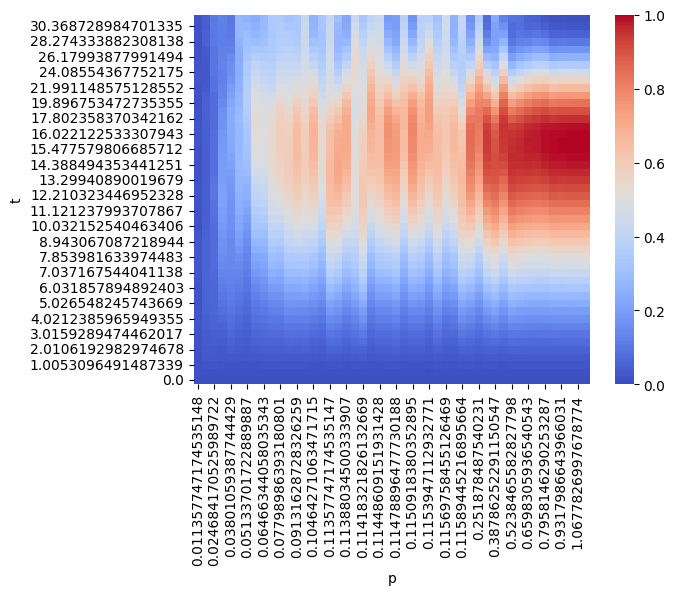

In [160]:
plot_heatmap(p_values=x, t_values=y, prob_values=z, num_ticks=40,round_val=3, filepath=None)